In [1]:
!pip install patchify

In [2]:
import datetime
import math
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import natsort
import glob

from enum import Enum
from PIL import Image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.models import Model, load_model
from keras.utils import to_categorical
from patchify import patchify
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.layers import Rescaling
from tqdm import tqdm

In [3]:
# image preprocessing

def load_images_and_patchify(directory_path, patch_size):
    """
    :param patch_size: image patchify square size
    :param directory_path: path to root directory containing training and test images
    :return: list of images from directory
    """

    # initialize empty list for images
    instances = []

    # iterate through files in directory
    for file_number, filepath in tqdm(enumerate(os.listdir(directory_path))):
        extension = filepath.split(".")[-1]
        if extension == "jpg" or extension == "png":

            # current image path
            img_path = rf"{directory_path}/{filepath}"

            # Reads image as BGR
            image = cv2.imread(img_path)

            # convert image to RBG
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            size_x = (image.shape[1] // patch_size) * patch_size  # width to the nearest size divisible by patch size
            size_y = (image.shape[0] // patch_size) * patch_size  # height to the nearest size divisible by patch size

            image = Image.fromarray(image)

            # Crop original image to size divisible by patch size from top left corner
            image = np.array(image.crop((0, 0, size_x, size_y)))

            # Extract patches from each image, step=patch_size means no overlap
            patch_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

            # iterate over vertical patch axis
            for j in range(patch_img.shape[0]):
                # iterate over horizontal patch axis
                for k in range(patch_img.shape[1]):
                    # patches are located like a grid. use (j, k) indices to extract single patched image
                    single_patch_img = patch_img[j, k]

                    # Drop extra dimension from patchify
                    instances.append(np.squeeze(single_patch_img))

    return instances


def reshape_images(instances):
    """
    :param instances: list of images
    :return: reshaped images
    """
    for j in range(len(instances)):
        instances[j] = instances[j].reshape(-1, 1)
    return instances


def get_minimum_image_size(instances):
    """
    :param instances: list of images
    :return: min and max dimensions out of all images
    """

    # initialize minimum values to infinity
    min_x = math.inf
    min_y = math.inf

    # loop through each instance
    for image in instances:
        # check min x (rows)
        min_x = image.shape[0] if image.shape[0] < min_x else min_x

        # check min y (columns)
        min_y = image.shape[1] if image.shape[1] < min_y else min_y

    return min_x, min_y


def display_images(instances, rows=2, titles=None):
    """
    :param instances:  list of images
    :param rows: number of rows in subplot
    :param titles: subplot titles
    :return:
    """
    n = len(instances)
    cols = n // rows if (n / rows) % rows == 0 else (n // rows) + 1

    # iterate through images and display subplots
    for j, image in enumerate(instances):
        plt.subplot(rows, cols, j + 1)
        plt.title('') if titles is None else plt.title(titles[j])
        plt.axis("off")
        plt.imshow(image)

    # show the figure
    plt.show()

In [4]:
# prepare training data input images
def get_training_data(root_directory):
    # initialise lists
    image_dataset, mask_dataset = [], []

    # define image patch size
    patch_size = 160

    # walk through root directory
    for path, directories, files in os.walk(root_directory):
        for subdirectory in directories:

            # extract training input images and patchify
            if subdirectory == "images":
                image_dataset.extend(
                    load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size))

            # extract training label masks and patchify
            elif subdirectory == "rgb":
                mask_dataset.extend(
                    load_images_and_patchify(os.path.join(path, subdirectory), patch_size=patch_size))

    # return input images and masks
    return np.array(image_dataset), np.array(mask_dataset)


def create_binary_segmentation_problem(image_dataset, mask_dataset):
    # change problem to binary segmentation problem
    x_reduced, y_reduced = [], []

    # iterate over masks
    for j, mask in tqdm(enumerate(mask_dataset)):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create binary image (zeros)
        binary_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        # iterate over each pixel in mask
        for row in range(_img_height):
            for col in range(_img_width):
                # get image channel across axis=3
                rgb = mask[row, col, :]

                # building hex: #3C1098 = RGB(60, 16, 152) or BGR(152, 16, 60)
                binary_image[row, col] = 1 if rgb[0] == 60 and rgb[1] == 16 and rgb[2] == 152 else 0

        # only keep images with a high percentage of building coverage
        if np.count_nonzero(binary_image == 1) > 0.15 * binary_image.size:
            x_reduced.append(image_dataset[j])
            y_reduced.append(binary_image)

    # return binary image dataset
    return np.array(x_reduced), np.array(y_reduced)

In [5]:
# mask color codes
class MaskColorMap(Enum):
    Background = (0, 0, 0)
    Dash_Line = (255, 0, 0)
    Long_Line = (0, 0, 255)
    Small_dash_line = (255, 255, 0)
    Turn_signs = (0, 255, 0)
    Other_signs = (255, 128, 0)
    Plus_sign_on_crossroads = (128, 0, 0)
    Crosswalk = (0, 255, 255)
    Stop_line = (0, 128, 0)
    Zebra_zone = (255, 0, 255)
    No_parking_zone = (0, 150, 150)
    Parking_space = (200, 200, 0)
    Other_lane_markings = (100, 0, 200)


def one_hot_encode_masks(masks, num_classes):
    """
    :param masks: Y_train patched mask dataset
    :param num_classes: number of classes
    :return:
    """
    # initialise list for integer encoded masks
    integer_encoded_labels = []

    # iterate over each mask
    for mask in tqdm(masks):

        # get image shape
        _img_height, _img_width, _img_channels = mask.shape

        # create new mask of zeros
        encoded_image = np.zeros((_img_height, _img_width, 1)).astype(int)

        for j, cls in enumerate(MaskColorMap):
            encoded_image[np.all(mask == cls.value, axis=-1)] = j

        # append encoded image
        integer_encoded_labels.append(encoded_image)

    # return one-hot encoded labels
    return to_categorical(y=integer_encoded_labels, num_classes=num_classes)

In [6]:
# output directories

# Generate current timestamp
dt_now = str(datetime.datetime.now()).replace(".", "_").replace(":", "_")

# Create models directory if it doesn't exist
models_directory = os.path.join(os.getcwd(), 'models')
os.makedirs(models_directory, exist_ok=True)

# Create logs directory if it doesn't exist
logs_directory = os.path.join(os.getcwd(), 'logs')
os.makedirs(logs_directory, exist_ok=True)

# Define model image save path
model_img_save_path = os.path.join(models_directory, f'final_aerial_segmentation_{dt_now}.png')

# Define model save path
model_save_path = os.path.join(models_directory, f'final_aerial_segmentation_{dt_now}.hdf5')

# Define model checkpoint filepath
model_checkpoint_filepath = os.path.join(models_directory, 'weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5')

# Define CSV logger path
csv_logger = os.path.join(logs_directory, f'aerial_segmentation_log_{dt_now}.csv')
csv_logger_callback = tf.keras.callbacks.CSVLogger(csv_logger)

In [7]:
# training metrics

# Mean Intersection-Over-Union: iou = true_positives / (true_positives + false_positives + false_negatives)
def iou_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, [1, 2, 3]) + K.sum(y_pred, [1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


# jaccard similarity: the size of the intersection divided by the size of the union of two sets
def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

1it [00:00,  1.09it/s]
1it [00:01,  1.11s/it]


number of patched image training data: 805


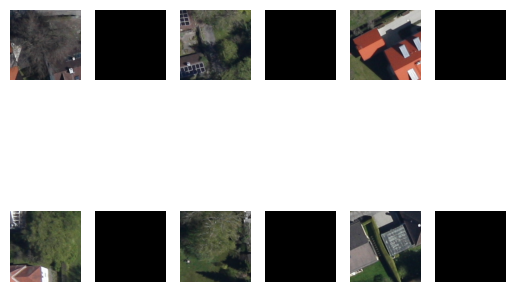

100%|██████████| 805/805 [00:08<00:00, 93.96it/s]


In [8]:
# get training data

# number of classes in segmentation dataset
n_classes = 13

# dataset directory
data_dir = r"/content/drive/MyDrive/Multi_lane"

# create (X, Y) training data
X, Y = get_training_data(root_directory=data_dir)

# extract X_train shape parameters
m, img_height, img_width, img_channels = X.shape
print('number of patched image training data:', m)

# display images from both training and test sets
display_count = 6
random_index = [np.random.randint(0, m) for _ in range(display_count)]
sample_images = [x for z in zip(list(X[random_index]), list(Y[random_index])) for x in z]
display_images(sample_images, rows=2)

# convert RGB values to integer encoded labels for categorical_crossentropy
Y = one_hot_encode_masks(Y, num_classes=n_classes)

# split dataset into training and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [9]:
# define U-Net model architecture

def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
    rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
    previous_block_activation = rescale  # Set aside residual

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [16, 32, 64, 128]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
            previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    # Expansive path: Second half of the network: upsampling inputs
    for f in reversed([16, 32, 64, 128]):
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)

In [10]:
# build model
model = build_unet(img_shape=(img_height, img_width, img_channels))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 160, 160, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 160, 160, 16)         448       ['rescaling[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, 160, 160, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [11]:
# add callbacks, compile model and fit training data

# save best model with maximum validation accuracy
checkpoint = ModelCheckpoint(model_checkpoint_filepath, monitor="val_accuracy", verbose=1, save_best_only=True,
                             mode="max")

# stop model training early if validation loss doesn't continue to decrease over 3 iterations
early_stopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1, mode="min")

# log training console output to csv
csv_logger = CSVLogger(csv_logger, separator=",", append=False)

# create list of callbacks
callbacks_list = [checkpoint, csv_logger]  # early_stopping

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy", iou_coefficient, jaccard_index])

# train and save model
model.fit(X_train, Y_train, epochs=20, batch_size=1, validation_data=(X_test, Y_test), callbacks=callbacks_list,
          verbose=1)
model.save(model_save_path)
print("model saved:", model_save_path)

Epoch 1/20
721/724 [============================>.] - ETA: 0s - loss: 0.1051 - accuracy: 0.9891 - iou_coefficient: 0.9553 - jaccard_index: 0.9553
Epoch 1: val_accuracy improved from -inf to 0.99469, saving model to /content/models/weights-improvement-01-0.99.hdf5
724/724 [==============================] - 22s 13ms/step - loss: 0.1046 - accuracy: 0.9892 - iou_coefficient: 0.9555 - jaccard_index: 0.9555 - val_loss: 0.0420 - val_accuracy: 0.9947 - val_iou_coefficient: 0.9699 - val_jaccard_index: 0.9699
Epoch 2/20
  1/724 [..............................] - ETA: 10s - loss: 0.0034 - accuracy: 1.0000 - iou_coefficient: 0.9934 - jaccard_index: 0.9934

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


720/724 [============================>.] - ETA: 0s - loss: 0.0295 - accuracy: 0.9958 - iou_coefficient: 0.9828 - jaccard_index: 0.9828
Epoch 2: val_accuracy did not improve from 0.99469
724/724 [==============================] - 9s 12ms/step - loss: 0.0295 - accuracy: 0.9958 - iou_coefficient: 0.9827 - jaccard_index: 0.9827 - val_loss: 0.0322 - val_accuracy: 0.9947 - val_iou_coefficient: 0.9734 - val_jaccard_index: 0.9734
Epoch 3/20
722/724 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9959 - iou_coefficient: 0.9849 - jaccard_index: 0.9849
Epoch 3: val_accuracy improved from 0.99469 to 0.99470, saving model to /content/models/weights-improvement-03-0.99.hdf5
724/724 [==============================] - 8s 12ms/step - loss: 0.0230 - accuracy: 0.9959 - iou_coefficient: 0.9850 - jaccard_index: 0.9850 - val_loss: 0.0313 - val_accuracy: 0.9947 - val_iou_coefficient: 0.9876 - val_jaccard_index: 0.9876
Epoch 4/20
720/724 [============================>.] - ETA: 0s - los

In [16]:
# load pre-trained model

model_dir = '/content/models/'
model_name = 'final_aerial_segmentation_2024-02-27 12_30_03_498262.hdf5'

model2 = load_model(model_dir + model_name, custom_objects={'iou_coefficient': iou_coefficient, 'jaccard_index': jaccard_index})


In [13]:
class_index = \
      {
  1:	[ (0, 0, 0),	'Background'],
  2:	[ (255, 0, 0),	'Dash_Line'],
  3:	[ (0, 0, 255), 	'Long_Line'],
  4:	[ (255, 255, 0),'Small_dash_line'],
  5:	[ (0, 255, 0),	'Turn_signs'],
  6:	[ (255, 128, 0), 'Other_signs'],
  7:	[ (128, 0, 0),	'Plus_sign_on_crossroads'],
  8:	[ (0, 255, 255), 'Crosswalk'],
  9:	[ (0, 128, 0),	'Stop_line'],
  10:	[ (255, 0, 255), 'Zebra_zone'],
  11:	[ (0, 150, 150), 'No_parking_zone'],
  12:	[ (200, 200, 0), 'Parking_space'],
  13:	[ (100, 0, 200), 'Other_lane_markings']
 }

def plot_color_legend(class_index):

    # Extract colors and labels from class_index dictionary.
    color_array = np.array([[v[0][0], v[0][1], v[0][2]] for v in class_index.values()]).astype(np.uint8)
    class_labels = [val[1] for val in class_index.values()]

    fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(12, 3))
    plt.subplots_adjust(wspace = 0.5, hspace=0.2)

    # Display color legend.
    for i, axis in enumerate(ax.flat):

        axis.imshow(color_array[i][None, None, :])
        axis.set_title(class_labels[i], fontsize = 8)
        axis.axis('off')

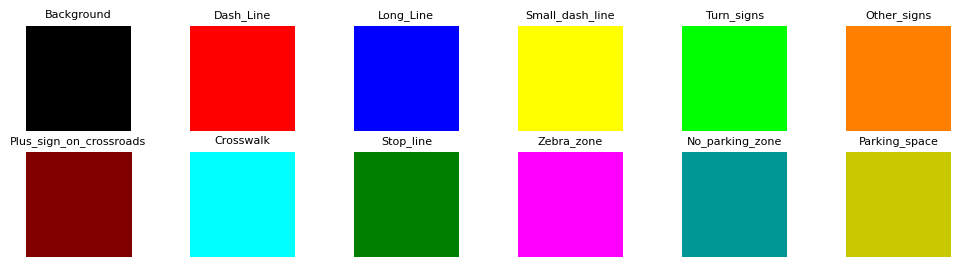

In [14]:
plot_color_legend(class_index)

1/1 [==============================] - 0s 245ms/step


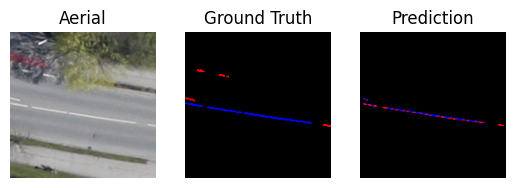

1/1 [==============================] - 0s 20ms/step


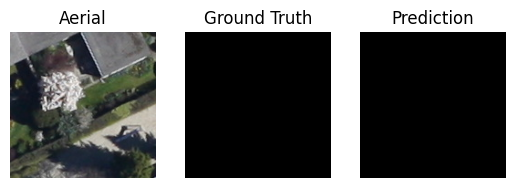

1/1 [==============================] - 0s 19ms/step


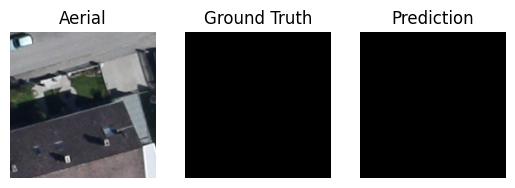

1/1 [==============================] - 0s 22ms/step


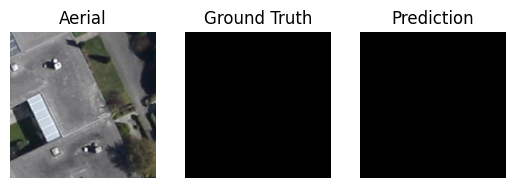

1/1 [==============================] - 0s 19ms/step


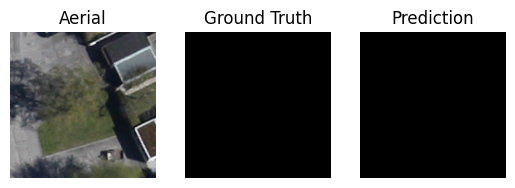

1/1 [==============================] - 0s 19ms/step


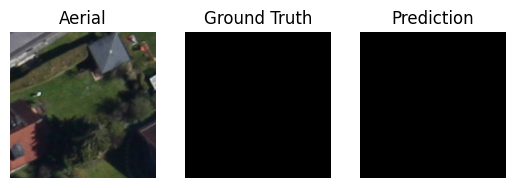

1/1 [==============================] - 0s 21ms/step


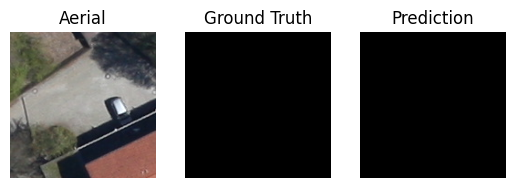

1/1 [==============================] - 0s 20ms/step


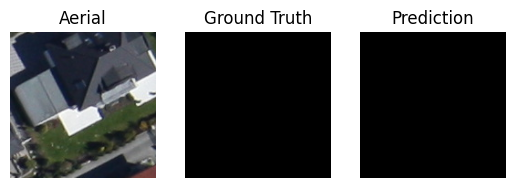

1/1 [==============================] - 0s 20ms/step


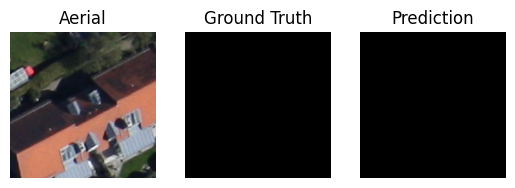

1/1 [==============================] - 0s 20ms/step


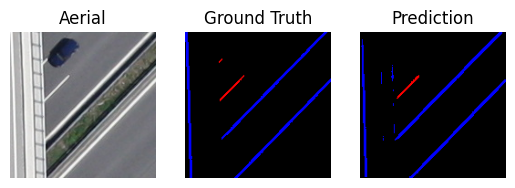

1/1 [==============================] - 0s 19ms/step


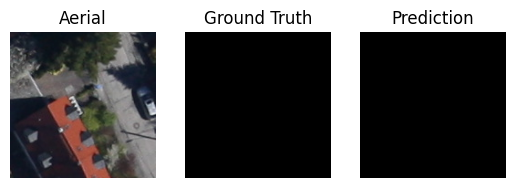

1/1 [==============================] - 0s 20ms/step


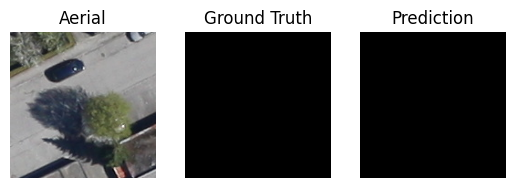

1/1 [==============================] - 0s 22ms/step


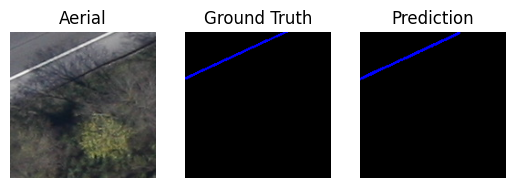

1/1 [==============================] - 0s 19ms/step


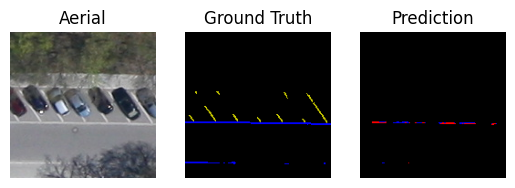

1/1 [==============================] - 0s 19ms/step


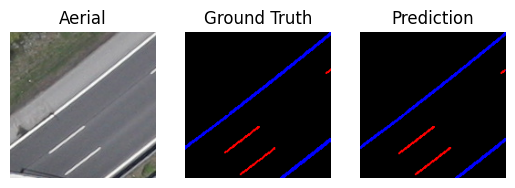

1/1 [==============================] - 0s 21ms/step


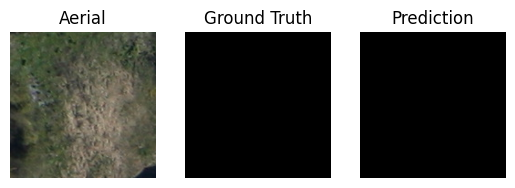

1/1 [==============================] - 0s 20ms/step


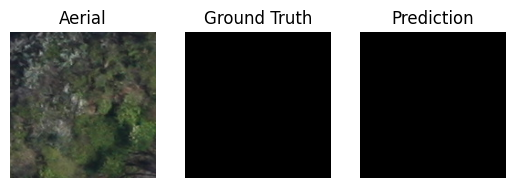

1/1 [==============================] - 0s 20ms/step


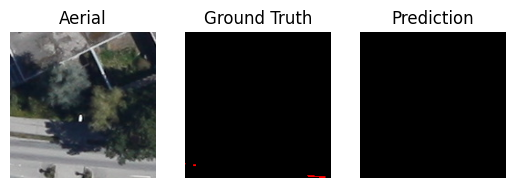

1/1 [==============================] - 0s 20ms/step


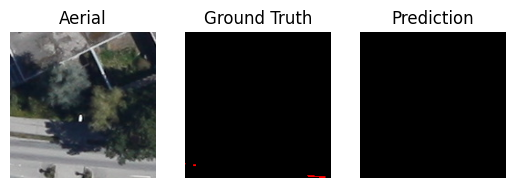

1/1 [==============================] - 0s 21ms/step


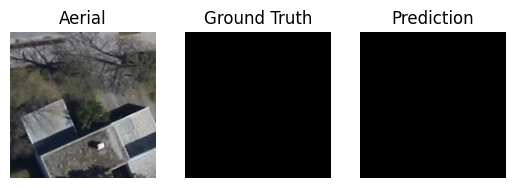

In [17]:
# Predict

def rgb_encode_mask(mask):
    # initialize rgb image with equal spatial resolution
    rgb_encode_image = np.zeros((mask.shape[0], mask.shape[1], 3))

    # iterate over MaskColorMap
    for j, cls in enumerate(MaskColorMap):
        # convert single integer channel to RGB channels
        rgb_encode_image[(mask == j)] = np.array(cls.value) / 255.
    return rgb_encode_image


for _ in range(20):
    # choose random number from 0 to test set size
    test_img_number = np.random.randint(0, len(X_test))

    # extract test input image
    test_img = X_test[test_img_number]

    # ground truth test label converted from one-hot to integer encoding
    ground_truth = np.argmax(Y_test[test_img_number], axis=-1)

    # expand first dimension as U-Net requires (m, h, w, nc) input shape
    test_img_input = np.expand_dims(test_img, 0)

    # make prediction with model and remove extra dimension
    prediction = np.squeeze(model2.predict(test_img_input))

    # convert softmax probabilities to integer values
    predicted_img = np.argmax(prediction, axis=-1)

    # convert integer encoding to rgb values
    rgb_image = rgb_encode_mask(predicted_img)
    rgb_ground_truth = rgb_encode_mask(ground_truth)

    # visualize model predictions
    display_images(
        [test_img, rgb_ground_truth, rgb_image],
        rows=1, titles=['Aerial', 'Ground Truth', 'Prediction']
    )